In [4]:
import numpy as np
import pandas as pd
import re
#import torch
import tensorflow as tf

In [5]:
df = pd.read_csv('/Users/lubicasimkovicova/Desktop/Bachelorthesis---Sentiment-Analysis-with-Deep-Learning-main-2/train.csv')

In [6]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
train = df.drop(['textID','text'],axis=1)

# Data Preprocessing

In [8]:
train.selected_text.fillna('No text',inplace=True)

In [9]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+','', text) #remove mentions
    text = re.sub(r'#','', text) #remove hash
    text = re.sub(r'https?:\/\/\S+', '', text) #remove hyperlink
    text = re.sub('\s+', ' ', text) #remove new line char
    text = re.sub("\'", "", text) #remove single quotes
    
    return text

In [10]:
train["selected_text"] = train["selected_text"].apply(cleantext)

In [11]:
train["selected_text"].head(15)

0                   I`d have responded, if I were going
1                                              Sooo SAD
2                                           bullying me
3                                        leave me alone
4                                         Sons of ****,
5      - some shameless plugging for the best Ranger...
6                                                   fun
7                                            Soooo high
8                                           Both of you
9                          Wow... u just became cooler.
10    as much as i love to be hopeful, i reckon the ...
11                                                 like
12                                          DANGERously
13                                                 lost
14                           test test from the LG enV2
Name: selected_text, dtype: object

In [12]:
import string
train["selected_text"] = train["selected_text"].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])

In [13]:
train["selected_text"] = train["selected_text"].apply(lambda wrd: ''.join(wrd))

In [14]:
train["selected_text"]

0                        id have responded if i were going
1                                                 sooo sad
2                                              bullying me
3                                           leave me alone
4                                                 sons of 
                               ...                        
27476                                               d lost
27477                                           dont force
27478                             yay good for both of you
27479                                 but it was worth it 
27480    all this flirting going on  the atg smiles yay...
Name: selected_text, Length: 27481, dtype: object

In [15]:
from nltk.corpus import stopwords

In [16]:
train["selected_text"][:50] = train["selected_text"][:50].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words("english")]))

In [17]:
train["selected_text"]

0                                       id responded going
1                                                 sooo sad
2                                                 bullying
3                                              leave alone
4                                                     sons
                               ...                        
27476                                               d lost
27477                                           dont force
27478                             yay good for both of you
27479                                 but it was worth it 
27480    all this flirting going on  the atg smiles yay...
Name: selected_text, Length: 27481, dtype: object

In [18]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),     deacc=True))

In [19]:
from nltk.tokenize.treebank import TreebankWordDetokenizer
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [20]:
temp = []
data_to_list = train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(data_to_list[i])
data_wordslem = list(sent_to_words(temp))

In [21]:
import nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

In [22]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/lubicasimkovicova/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [23]:
for i in range(len(data_wordslem)):
    for j in range(len(data_wordslem[i])):
        data_wordslem[i][j] = lemmatizer.lemmatize(data_wordslem[i][j],pos="v")

In [24]:
data = []
for i in range(len(data_wordslem)):
    data.append(detokenize(data_wordslem[i]))
print(data[:5])

['id respond go', 'sooo sad', 'bully', 'leave alone', 'sons']


# Building a Model

In [25]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers

# Tokenizing and adding padding

In [26]:
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  290 1026   15]
 [   0    0    0 ...    0  399   64]
 [   0    0    0 ...    0    0 3103]
 ...
 [   0    0    0 ...  379   12    5]
 [   0    0    0 ...    1  533    8]
 [   0    0    0 ...  548  196  398]]


In [27]:
from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

# Using BiDirectional RNN and LSTM

In [28]:
from keras.models import Sequential
from keras import layers

model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))

In [29]:
model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Label Encoding of output

In [30]:
import tensorflow as tf
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

# Training the Model

In [31]:
history = model2.fit(x = tweets, y= labels, epochs=80,validation_split=0.2)

Epoch 1/80
687/687 [==============================] - 16s 21ms/step - loss: 0.6985 - accuracy: 0.7087 - val_loss: 0.5163 - val_accuracy: 0.7910
Epoch 2/80
687/687 [==============================] - 15s 22ms/step - loss: 0.4584 - accuracy: 0.8246 - val_loss: 0.4509 - val_accuracy: 0.8323
Epoch 3/80
687/687 [==============================] - 15s 22ms/step - loss: 0.3955 - accuracy: 0.8540 - val_loss: 0.4406 - val_accuracy: 0.8330
Epoch 4/80
687/687 [==============================] - 15s 22ms/step - loss: 0.3637 - accuracy: 0.8651 - val_loss: 0.4345 - val_accuracy: 0.8392
Epoch 5/80
687/687 [==============================] - 16s 23ms/step - loss: 0.3385 - accuracy: 0.8742 - val_loss: 0.4442 - val_accuracy: 0.8341
Epoch 6/80
687/687 [==============================] - 16s 23ms/step - loss: 0.3173 - accuracy: 0.8821 - val_loss: 0.4514 - val_accuracy: 0.8368
Epoch 7/80
687/687 [==============================] - 16s 23ms/step - loss: 0.3081 - accuracy: 0.8872 - val_loss: 0.4533 - val_accuracy:

In [32]:
import matplotlib.pyplot as plt

# Visualizing Loss

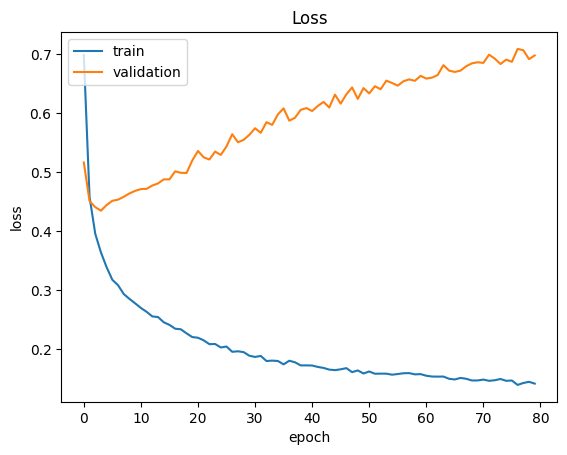

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

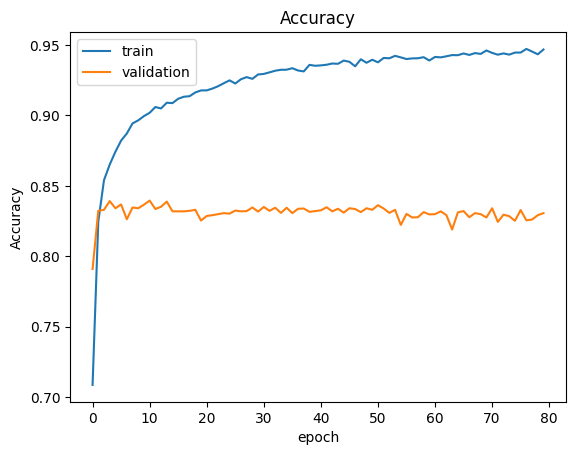

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Prediction and Result

In [47]:
sentiment = ['Neutral','Negative','Positive']

In [48]:
sequence = tokenizer.texts_to_sequences(['this experience has been the worst, very bad product'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 1s 518ms/step


'Negative'

In [49]:
sequence = tokenizer.texts_to_sequences(['i really love this internship'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 24ms/step


'Positive'

In [50]:
sequence = tokenizer.texts_to_sequences(['i love sayabidevs'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 22ms/step


'Positive'

In [54]:
sequence = tokenizer.texts_to_sequences(['I go to gym daily'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(model2.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 59ms/step


'Neutral'

In [36]:
# saving the model
model2.save("/Users/lubicasimkovicova/Desktop/Bachelorthesis---Sentiment-Analysis-with-Deep-Learning-main-2/model")

INFO:tensorflow:Assets written to: /Users/lubicasimkovicova/Desktop/Bachelorthesis---Sentiment-Analysis-with-Deep-Learning-main-2/model/assets


INFO:tensorflow:Assets written to: /Users/lubicasimkovicova/Desktop/Bachelorthesis---Sentiment-Analysis-with-Deep-Learning-main-2/model/assets
